<a href="https://colab.research.google.com/github/xxziris/protein_ligand_binding/blob/main/BS6207_Project_big_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install sparse

     |████████████████████████████████| 81kB 3.1MB/s 


In [ ]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from sparse import COO
import sparse
import matplotlib.pyplot as plt

## 1. Read Data

- import data from pdb file
- generate negative cases
- train_validation split
- voxelize the training/validation data
- generate train/test dataloader

In [ ]:
# define function to import data from pdb files
def read_pdb(filename):
	
  with open(filename, 'r') as file:
    strline_L = file.readlines()
		# print(strline_L)

  X_list = list()
  Y_list = list()
  Z_list = list()
  atomtype_list = list()
  for strline in strline_L:
		# removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
    stripped_line = strline.strip()

    line_length = len(stripped_line)
		# print("Line length:{}".format(line_length))
    if line_length < 78:
      print("ERROR: line length is different. Expected>=78, current={}".format(line_length))
		
    X_list.append(float(stripped_line[30:38].strip()))
    Y_list.append(float(stripped_line[38:46].strip()))
    Z_list.append(float(stripped_line[46:54].strip()))

    atomtype = stripped_line[76:78].strip()
    if atomtype == 'C':
      atomtype_list.append(1) # 'h' means hydrophobic
    else:
      atomtype_list.append(0) # 'p' means polar

  pdb = np.array([X_list, Y_list, Z_list, atomtype_list])
	
  return pdb


In [ ]:
# read all training filenames
import os

pro_filename = []
lg_filename = []
directory = os.fsencode('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/training_data/')
    
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if '_pro_' in filename: 
       pro_filename.append(os.path.join('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/training_data/', filename))
       continue
     else:
       lg_filename.append(os.path.join('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/training_data/', filename))
       continue

In [ ]:
len(pro_filename)

3000

In [ ]:
len(lg_filename)

3000

In [ ]:
# create the label
def get_label(pro, lig):
  labels = []
  num = min(len(pro), len(lig))
  for i in range(num):
    if pro[i][-15:-11] == lig[i][-15:-11]:
      labels.append(1) # bind
    else:
      labels.append(0) #dont bind
  return labels

In [ ]:
# define a function to generate training/validation set with pos/neg ratio
# function returns two lists of tuples for training/validation set
# each tuple contains the protein filename, ligand filename and the corresponding label
def train_val_split(pro_filename = pro_filename, lg_filename = lg_filename, neg_pos_ratio = 1, val_perc = 0.2):
  # sort the protein and ligand filename list
  lg_filename = sorted(lg_filename)
  pro_filename = sorted(pro_filename)

  # randomly sort the filename to generate negative cases
  random.seed(127)
  tot_lig_filename = lg_filename.copy()
  tot_pro_filename = pro_filename.copy()
  for i in range(neg_pos_ratio):
    #print(len(lg_filename))
    lg_filename_rand = lg_filename.copy()
    random.shuffle(lg_filename_rand)
    tot_lig_filename += lg_filename_rand
    pro_filename_rand = pro_filename.copy()
    random.shuffle(pro_filename_rand)
    tot_pro_filename += pro_filename_rand
  
  # get labels of the list
  label = get_label(tot_pro_filename, tot_lig_filename)
  print('Total positive cases: ', label.count(0), 'Total negative cases: ', label.count(1))

  # train_validation split
  val_size = round(len(label) * val_perc)
  #print(val_size)
  index = random.sample(range(0,len(label)), val_size) 
  val_lig = [tot_lig_filename[i] for i in index]
  val_pro = [tot_pro_filename[i] for i in index]
  val_label = [label[i] for i in index]
  val_label = np.array(val_label)
  print('Positive cases in validation: ', list(val_label).count(0), 
        'Negative cases in validation: ', list(val_label).count(1))

  # the rest will be training set
  train_index = list(set(range(len(label))) - set(index))
  train_lig = [tot_lig_filename[i] for i in train_index]
  train_pro = [tot_pro_filename[i] for i in train_index]
  train_label = [label[i] for i in train_index]
  train_label = np.array(train_label)
  print('Positive cases in training: ', list(train_label).count(0), 
        'Negatvie cases in training: ', list(train_label).count(1))
  
  # shuffle the validation set sequence
  all_val = []
  for i in range(len(val_label)):
    all_val.append((val_pro[i], val_lig[i], val_label[i]))
  all_val = random.sample(all_val, k = len(all_val))

  # shuffle the training  set sequence
  all_train = []
  for i in range(len(train_label)):
    all_train.append((train_pro[i], train_lig[i], train_label[i]))
  all_train[:5]
  all_train = random.sample(all_train, k = len(all_train))

  return all_train, all_val

In [ ]:
# define function for voxelization
def voxelize(pro_filename, lig_filename, max_side = 30, grid = 4):
  # import the pdb file as array
  pro = read_pdb(pro_filename).astype(np.float32)
  lig = read_pdb(lig_filename).astype(np.float32)

  # calculate box_size
  box_size = np.ceil(2 * max_side / grid + 1)

  # get the centroid of the ligand/protein
  lig_cent = np.mean(lig[:3, :], axis = 1, keepdims = True)  
  pro_cent = np.mean(pro[:3, :], axis = 1, keepdims = True)

  # shift the protein by the centroid of ligand at 0
  for i in range(3):
    lig[i] = lig[i] - lig_cent[i]
    pro[i] = pro[i] - lig_cent[i]
  
  # combine the coordinate and atom type of protein and ligand
  all_coord = np.c_[pro[:3], lig[:3]]
  lig[3] = np.where(lig[3] == 0, 100, 200)
  all_atom = np.r_[pro[3], lig[3]]

  # round coordinate to the nearest grid point
  all_coord = (all_coord + max_side) / grid
  
  # remove atoms outside the box
  check = ((all_coord>0) & (all_coord < box_size)).all(axis = 0)
  all_coord = all_coord[:,check]
  all_atom = all_atom[check]

  # round the coordinates to integer
  all_coord = (all_coord).astype(int)

  # create the sparse matrix
  s = sparse.COO(all_coord, all_atom, shape = (int(box_size), int(box_size), int(box_size)))  
  return s

In [ ]:
# define function to build dataloader for the neural network
# function returns the dataloader for both train and validation
def dataloader_builder(all_train, all_val, batch_size = 128, max_side = 30, grid = 4):
  # load the training sparse 3d matrix
  print(max_side, grid)
  train_cube = []
  for i in range(len(all_train)):
    temp = voxelize(all_train[i][0], all_train[i][1], max_side, grid)
    train_cube.append(COO.todense(temp))
  train_cube = np.array(train_cube)
  train_cube = train_cube.reshape(train_cube.shape[0], 1, train_cube.shape[1], train_cube.shape[2], train_cube.shape[3])
  print(train_cube.shape)
  print(np.ceil(2 * max_side / grid + 1))

  # build the train dataloader
  train_data = []
  for i in range(len(all_train)):
    train_data.append([train_cube[i], all_train[i][2]])
  trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = batch_size) 

  # load the validation sparse 3d matrix
  val_cube = []
  for i in range(len(all_val)):
    temp = voxelize(all_val[i][0], all_val[i][1], max_side, grid)
    val_cube.append(COO.todense(temp))
  val_cube = np.array(val_cube)
  val_cube = val_cube.reshape(val_cube.shape[0], 1, val_cube.shape[1], val_cube.shape[2], val_cube.shape[3])
  print(val_cube.shape)

  # build the validation dataloader
  val_data = []
  for i in range(len(all_val)):
    val_data.append([val_cube[i], all_val[i][2]])
  valloader = torch.utils.data.DataLoader(val_data, shuffle = True, batch_size = batch_size)

  return trainloader, valloader

In [ ]:
# define function to plot confusion matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [ ]:
# define function to reset model weight
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

In [ ]:
# define function to calculate accuracy
def accuracy(outputs, labels):
    #preds = torch.round(outputs)
    y_pred_softmax = torch.log_softmax(outputs, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

## Build the neural network

### Trial 1 - 1:1 pos/neg

In [ ]:
# trail 1 - 1:1 pos/neg ratio, 15% validation
all_train1, all_val1 = train_val_split(val_perc = 0.15)
trainloader1, valloader1 = dataloader_builder(all_train1, all_val1, max_side = 24, grid = 2)

Total positive cases:  3000 Total negative cases:  3000
Positive cases in validation:  443 Negative cases in validation:  457
Positive cases in training:  2557 Negatvie cases in training:  2543
24 2
(5100, 1, 25, 25, 25)
25.0
(900, 1, 25, 25, 25)


In [ ]:
# trial 1 - CNN
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.cnn_layers = nn.Sequential(
        nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=0),
        nn.BatchNorm3d(8),
        nn.ReLU(inplace=True),
        nn.MaxPool3d(kernel_size=2, stride=1),
        # Defining another 2D convolution layer
        nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=0),
        nn.BatchNorm3d(16),
        nn.ReLU(inplace=True),
        nn.MaxPool3d(kernel_size=2, stride=2),
        # Defining another 2D convolution layer
        nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=0),
        nn.BatchNorm3d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool3d(kernel_size=2, stride=2),
    )

    self.linear_layers = nn.Sequential(
            nn.Dropout(p = 0.4),
            nn.Linear(32 * 4 * 4 * 4 , 32),
            nn.ReLU(),
            nn.Linear(32,2)
        )

  def forward(self, x):
    x = self.cnn_layers(x)
    x = torch.flatten(x, start_dim = 1)
    x = self.linear_layers(x)
    return x

In [ ]:
from torch.optim import Adam
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0005, weight_decay = 0.005)
# defining the loss function
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (9): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=2048, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_

In [ ]:
# number of parameters in the model
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

83298

In [ ]:
# define each epoch when training
def train(epoch, trainloader, valloader):
  train.train_loss = 0
  train.train_acces = 0
  model.train()
  total = 0
  correct = 0
  for images, labels in trainloader:
    #print(images.shape, labels.shape)
    optimizer.zero_grad() # clear the gradient
    output_train = model(images)   # calculate model output 
    #loss_train = criterion(output_train.squeeze(), labels) # calculate loss
    loss_train = criterion(output_train, labels)
        
    loss_train.backward()   # back propagation
    optimizer.step() # update model weights
        
    train.train_loss += loss_train.item() * images.size(0)
    acc = accuracy(output_train, labels)
    train.train_acces += acc
    

  print("Epoch {} - Training loss: {}, Training Accuracy: {}".format(epoch+1, train.train_loss / len(trainloader), train.train_acces / len(trainloader)))
  model.eval() 
  with torch.no_grad():
    train.val_acces = 0
    train.val_loss = 0
    for images, labels in valloader:
      output_val = model(images)
      #loss_val = criterion(output_val.squeeze(), labels)
      loss_val = criterion(output_val, labels)

      train.val_loss += loss_val.item() * images.size(0)
      #val_acc = accuracy_quick(output_train, labels)
      #val_acces += val_acc.item()     
      acc = accuracy(output_val, labels)   
      train.val_acces += acc
  
  print("Validation loss: {}, Validation Accuracy: {}".format(train.val_loss / len(valloader), train.val_acces / len(valloader)))


In [ ]:
model.apply(weight_reset)

Net(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (9): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=2048, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_

In [ ]:
# defining the number of epochs
n_epochs = 50
# empty list to store training losses
train_losses1 = []
train_acc1 = []
# empty list to store validation losses
val_losses1 = []
val_acc1 =[]
epoch_count1 = []
# training the model
es = 0
best_loss = 100
for epoch in range(n_epochs):
    train(epoch, trainloader = trainloader1, valloader = valloader1)
    epoch_count1.append(epoch)
    train_losses1.append(train.train_loss/len(trainloader1))
    val_losses1.append(train.val_loss/len(valloader1))
    train_acc1.append(train.train_acces/len(trainloader1))
    val_acc1.append(train.val_acces/len(valloader1))
    # early stopping
    if train.val_loss/len(valloader1) < best_loss:
      best_loss = train.val_loss/len(valloader1)
      es = 0
      torch.save(model.state_dict(), "model_" + str(epoch) + 'weight_trial1.pt')
      best_epoch = epoch
    else:
      es += 1
      print("Counter {} of 13".format(es))

    if es > 12:
      print("Early stopping!")
      model.load_state_dict(torch.load('/content/model_' + str(best_epoch) +'weight_trial1.pt'))
      break

Epoch 1 - Training loss: 90.3507786333561, Training Accuracy: 0.4966796934604645
Validation loss: 78.08993577957153, Validation Accuracy: 0.4697265625
Epoch 2 - Training loss: 88.4119248688221, Training Accuracy: 0.507703959941864
Validation loss: 78.0156481564045, Validation Accuracy: 0.505859375
Epoch 3 - Training loss: 88.09269658327102, Training Accuracy: 0.5277994871139526
Validation loss: 77.5916360616684, Validation Accuracy: 0.5439453125
Epoch 4 - Training loss: 79.95957681536674, Training Accuracy: 0.6709780097007751
Validation loss: 72.43328818678856, Validation Accuracy: 0.5576171875
Epoch 5 - Training loss: 33.3654976695776, Training Accuracy: 0.9174841046333313
Validation loss: 34.3320527728647, Validation Accuracy: 0.87109375
Epoch 6 - Training loss: 28.748764711618424, Training Accuracy: 0.9244429469108582
Validation loss: 21.54221085458994, Validation Accuracy: 0.9453125
Epoch 7 - Training loss: 27.02260620892048, Training Accuracy: 0.9282624125480652
Validation loss: 2

Text(0, 0.5, 'loss')

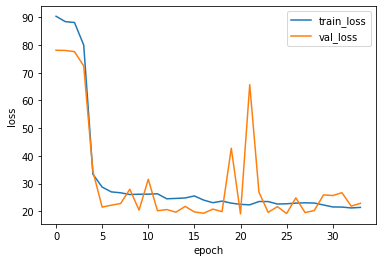

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch_count1, train_losses1, label = 'train_loss')
plt.plot(epoch_count1, val_losses1, label = 'val_loss')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

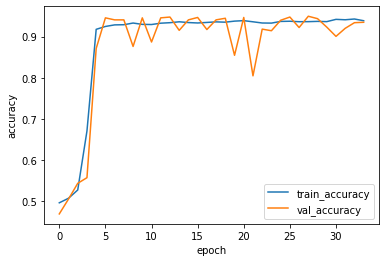

In [ ]:
plt.plot(epoch_count1, train_acc1, label = 'train_accuracy')
plt.plot(epoch_count1, val_acc1, label = 'val_accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('accuracy')

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/model_27weight_trial1_bigmatrix.pt'))

<All keys matched successfully>

Normalized confusion matrix
[[0.91422122 0.08577878]
 [0.03719912 0.96280088]]


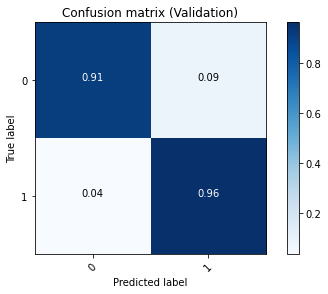

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valloader1:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix (Validation)')

Normalized confusion matrix
[[0.90731326 0.09268674]
 [0.02634683 0.97365317]]


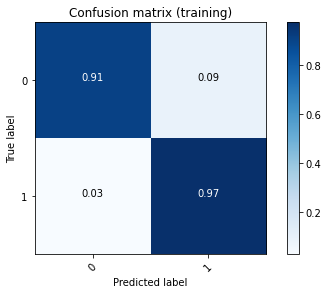

In [ ]:
# confusion matrix for trainloader
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in trainloader1:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix (training)')

In [ ]:
# load the validation sparse 3d matrix
valtest_cube = []
for i in range(len(all_val1)):
  temp = voxelize(all_val1[i][0], all_val1[i][1], max_side = 24, grid = 2)
  valtest_cube.append(COO.todense(temp))
valtest_cube = np.array(valtest_cube)
valtest_cube = valtest_cube.reshape(valtest_cube.shape[0], 1, valtest_cube.shape[1], valtest_cube.shape[2], valtest_cube.shape[3])
print(valtest_cube.shape)

# build the validation dataloader
valtest_data = []
count = 0
for i in range(len(all_val1)):
  if all_val1[i][2] == 0:
    #print(0)
    pass
  elif (all_val1[i][2] == 1) & (count < 50):
    count += 1
    pass
  else:
    continue
  valtest_data.append([valtest_cube[i], all_val1[i][2]])
valtest_loader = torch.utils.data.DataLoader(valtest_data, shuffle = True)
print(len(valtest_loader))

(900, 1, 25, 25, 25)
493


Normalized confusion matrix
[[0.91422122 0.08577878]
 [0.08       0.92      ]]


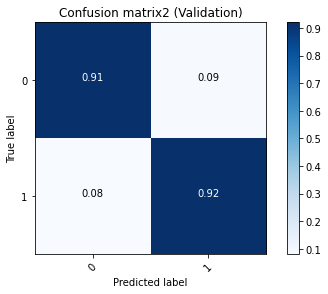

In [ ]:
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valtest_loader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')

### Trial 2 - 1:2 pos/neg

In [ ]:
# trail 2 - 1:2 pos/neg ratio, 15% validation
all_train2, all_val2 = train_val_split(val_perc = 0.15, neg_pos_ratio = 2)
trainloader2, valloader2 = dataloader_builder(all_train2, all_val2, max_side = 24, grid = 2)

Total positive cases:  5997 Total negative cases:  3003
Positive cases in validation:  896 Negative cases in validation:  454
Positive cases in training:  5101 Negatvie cases in training:  2549
24 2
(7650, 1, 25, 25, 25)
25.0
(1350, 1, 25, 25, 25)


In [ ]:
np.array(all_train2).shape

(7650, 3)

In [ ]:
model.apply(weight_reset)

Net(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (9): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=2048, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_

In [ ]:
# defining the number of epochs
n_epochs = 50
# empty list to store training losses
train_losses2 = []
train_acc2 = []
# empty list to store validation losses
val_losses2 = []
val_acc2 =[]
epoch_count2 = []
# training the model
es = 0
best_loss = 100
for epoch in range(n_epochs):
    train(epoch, trainloader = trainloader2, valloader = valloader2)
    epoch_count2.append(epoch)
    train_losses2.append(train.train_loss/len(trainloader2))
    val_losses2.append(train.val_loss/len(valloader2))
    train_acc2.append(train.train_acces/len(trainloader2))
    val_acc2.append(train.val_acces/len(valloader2))
    # early stopping
    if train.val_loss/len(valloader2) < best_loss:
      best_loss = train.val_loss/len(valloader2)
      es = 0
      torch.save(model.state_dict(), "model_" + str(epoch) + 'weight_trial2.pt')
      best_epoch = epoch
    else:
      es += 1
      print("Counter {} of 13".format(es))

    if es > 12:
      print("Early stopping!")
      model.load_state_dict(torch.load('/content/model_' + str(best_epoch) +'weight_trial2.pt'))
      break

Epoch 1 - Training loss: 85.00662438074748, Training Accuracy: 0.6587000489234924
Validation loss: 80.65485673600978, Validation Accuracy: 0.6687297224998474
Epoch 2 - Training loss: 82.29512592951457, Training Accuracy: 0.6667038798332214
Validation loss: 78.34186675331809, Validation Accuracy: 0.6628449559211731
Epoch 3 - Training loss: 81.21076027750969, Training Accuracy: 0.6667038798332214
Validation loss: 78.23039852489124, Validation Accuracy: 0.6616680026054382
Epoch 4 - Training loss: 80.99569689234097, Training Accuracy: 0.6667835712432861
Validation loss: 78.09251841631803, Validation Accuracy: 0.6646103858947754
Epoch 5 - Training loss: 76.78641922275226, Training Accuracy: 0.6669749021530151
Validation loss: 66.61917738481002, Validation Accuracy: 0.6581372022628784
Epoch 6 - Training loss: 34.26551362176736, Training Accuracy: 0.896675705909729
Validation loss: 22.2176990238103, Validation Accuracy: 0.9282873272895813
Epoch 7 - Training loss: 27.70250335385402, Training A

Text(0, 0.5, 'loss')

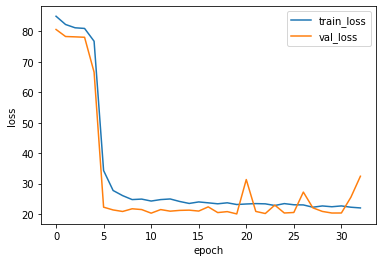

In [ ]:
plt.plot(epoch_count2, train_losses2, label = 'train_loss')
plt.plot(epoch_count2, val_losses2, label = 'val_loss')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

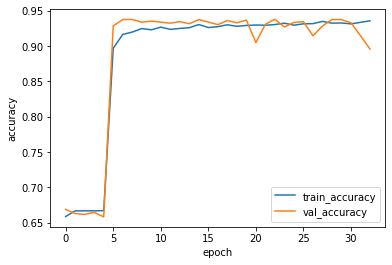

In [ ]:
plt.plot(epoch_count2, train_acc2, label = 'train_accuracy')
plt.plot(epoch_count2, val_acc2, label = 'val_accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('accuracy')

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/model_36weight_trial2_bigmatrix.pt'))

<All keys matched successfully>

Normalized confusion matrix
[[0.93080357 0.06919643]
 [0.05286344 0.94713656]]


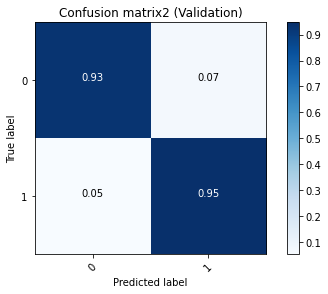

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valloader2:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')

Normalized confusion matrix
[[0.92374044 0.07625956]
 [0.04001569 0.95998431]]


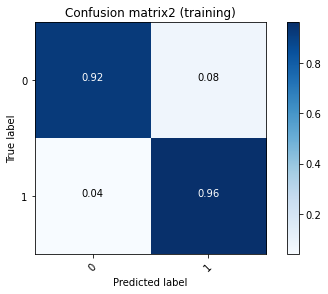

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in trainloader2:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (training)')

In [ ]:
# load the validation sparse 3d matrix
valtest_cube = []
for i in range(len(all_val2)):
  temp = voxelize(all_val2[i][0], all_val2[i][1], max_side = 24, grid = 2)
  valtest_cube.append(COO.todense(temp))
valtest_cube = np.array(valtest_cube)
valtest_cube = valtest_cube.reshape(valtest_cube.shape[0], 1, valtest_cube.shape[1], valtest_cube.shape[2], valtest_cube.shape[3])
print(valtest_cube.shape)

# build the validation dataloader
valtest_data = []
count = 0
count2 = 0
for i in range(len(all_val2)):
  if (all_val2[i][2] == 0) & (count2 < 500):
    count2 += 1
    #print(0)
    pass
  elif (all_val2[i][2] == 1) & (count < 50):
    count += 1
    pass
  else:
    continue
  valtest_data.append([valtest_cube[i], all_val2[i][2]])
valtest_loader = torch.utils.data.DataLoader(valtest_data, shuffle = True)

(1350, 1, 25, 25, 25)


Normalized confusion matrix
[[0.924 0.076]
 [0.04  0.96 ]]


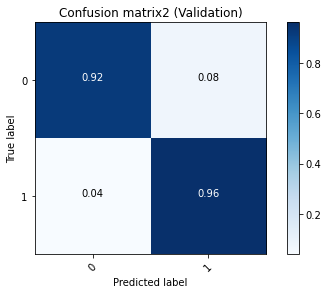

In [ ]:
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valtest_loader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')

### Trial 3 - 1:3 pos/neg

In [ ]:
# trail 3 - 1:3 pos/neg ratio, 15% validation
all_train3, all_val3 = train_val_split(val_perc = 0.15, neg_pos_ratio = 3)
trainloader3, valloader3 = dataloader_builder(all_train3, all_val3, max_side = 24, grid = 2)

Total positive cases:  8995 Total negative cases:  3005
Positive cases in validation:  1339 Negative cases in validation:  461
Positive cases in training:  7656 Negatvie cases in training:  2544
24 2
(10200, 1, 25, 25, 25)
25.0
(1800, 1, 25, 25, 25)


In [ ]:
model.apply(weight_reset)

Net(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (9): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=2048, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_

In [ ]:
# defining the number of epochs
n_epochs = 50
# empty list to store training losses
train_losses3 = []
train_acc3 = []
# empty list to store validation losses
val_losses3 = []
val_acc3 =[]
epoch_count3 = []
# training the model
es = 0
best_loss = 100
for epoch in range(n_epochs):
    train(epoch, trainloader = trainloader3, valloader = valloader3)
    epoch_count3.append(epoch)
    train_losses3.append(train.train_loss/len(trainloader3))
    val_losses3.append(train.val_loss/len(valloader3))
    train_acc3.append(train.train_acces/len(trainloader3))
    val_acc3.append(train.val_acces/len(valloader3))
    # early stopping
    if train.val_loss/len(valloader3) < best_loss:
      best_loss = train.val_loss/len(valloader3)
      es = 0
      torch.save(model.state_dict(), "model_" + str(epoch) + 'weight_trial3.pt')
      best_epoch = epoch
    else:
      es += 1
      print("Counter {} of 13".format(es))

    if es > 12:
      print("Early stopping!")
      model.load_state_dict(torch.load('/content/model_' + str(best_epoch) +'weight_trial3.pt'))
      break

Epoch 1 - Training loss: 72.8957184702158, Training Accuracy: 0.7416282296180725
Validation loss: 65.61636479695638, Validation Accuracy: 0.7598958611488342
Epoch 2 - Training loss: 47.94521414041519, Training Accuracy: 0.8180575370788574
Validation loss: 32.195090754826865, Validation Accuracy: 0.9114583134651184
Epoch 3 - Training loss: 31.71533186882734, Training Accuracy: 0.9103692770004272
Validation loss: 27.765182367960612, Validation Accuracy: 0.9302083253860474
Epoch 4 - Training loss: 28.589565731585026, Training Accuracy: 0.9151722192764282
Validation loss: 22.011928008000055, Validation Accuracy: 0.9291666746139526
Epoch 5 - Training loss: 25.289569607377054, Training Accuracy: 0.9153941869735718
Validation loss: 21.783191208044688, Validation Accuracy: 0.9338541626930237
Epoch 6 - Training loss: 24.74051613509655, Training Accuracy: 0.9201882481575012
Validation loss: 22.638839425643287, Validation Accuracy: 0.9302083253860474
Counter 1 of 13
Epoch 7 - Training loss: 24.34

Text(0, 0.5, 'loss')

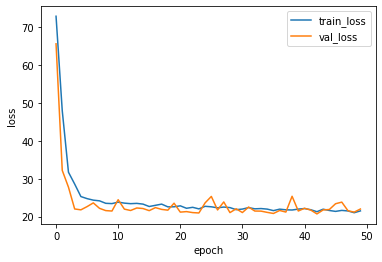

In [ ]:
plt.plot(epoch_count3, train_losses3, label = 'train_loss')
plt.plot(epoch_count3, val_losses3, label = 'val_loss')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

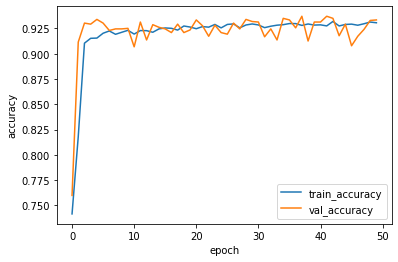

In [ ]:
plt.plot(epoch_count3, train_acc3, label = 'train_accuracy')
plt.plot(epoch_count3, val_acc3, label = 'val_accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('accuracy')

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/model_26weight_trial3_bigmatrix.pt'))

<All keys matched successfully>

Normalized confusion matrix
[[0.94100075 0.05899925]
 [0.10629067 0.89370933]]


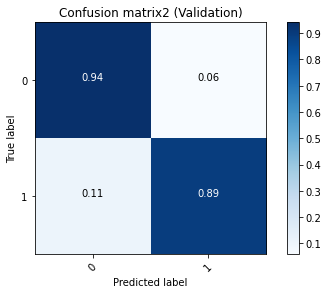

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valloader3:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')

Normalized confusion matrix
[[0.94357367 0.05642633]
 [0.07743711 0.92256289]]


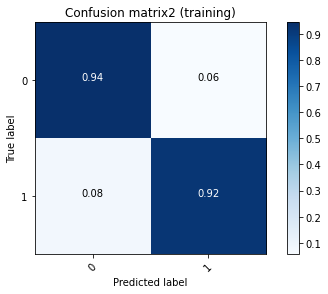

In [ ]:
# confusion matrix for validation
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in trainloader3:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (training)')

In [ ]:
# load the validation sparse 3d matrix
valtest_cube = []
for i in range(len(all_val3)):
  temp = voxelize(all_val3[i][0], all_val3[i][1], max_side = 24, grid = 2)
  valtest_cube.append(COO.todense(temp))
valtest_cube = np.array(valtest_cube)
valtest_cube = valtest_cube.reshape(valtest_cube.shape[0], 1, valtest_cube.shape[1], valtest_cube.shape[2], valtest_cube.shape[3])
print(valtest_cube.shape)

# build the validation dataloader
valtest_data = []
count = 0
count2 = 0
for i in range(len(all_val3)):
  if (all_val3[i][2] == 0) & (count2 < 500):
    count2 += 1
    #print(0)
    pass
  elif (all_val3[i][2] == 1) & (count < 50):
    count += 1
    pass
  else:
    continue
  valtest_data.append([valtest_cube[i], all_val3[i][2]])
valtest_loader = torch.utils.data.DataLoader(valtest_data, shuffle = True)

(1800, 1, 25, 25, 25)


Normalized confusion matrix
[[0.934 0.066]
 [0.02  0.98 ]]


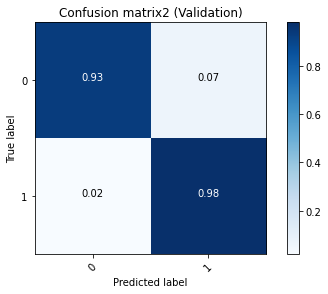

In [ ]:
model.eval() 
with torch.no_grad():
  y_pred = []
  y_true = []
  for images, labels in valtest_loader:
    y_true.extend(labels)
    output_val = model(images)
    y_pred_softmax = torch.log_softmax(output_val, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim=1)
    preds = preds.detach().numpy()
    y_pred.extend(preds)
from sklearn.metrics import confusion_matrix
# get actual label
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0,1], normalize = True, title = 'Confusion matrix2 (Validation)')